## Modules

In [149]:
from keras.layers import Input, Dense, Dropout
from keras.models import Model
from keras.datasets import mnist
from keras.models import Sequential, load_model
from keras.optimizers import RMSprop
from keras.callbacks import TensorBoard
from __future__ import print_function

import keras
import matplotlib.pyplot as plt
import numpy as np
import math

# Single layer autoencoder

## Data import and preprocessing

All data is normalized and serialized into a vector.

In [150]:
(x_train, y_train), (x_val, y_val) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_val = x_val.astype('float32') / 255.

x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_val = x_val.reshape((len(x_val), np.prod(x_val.shape[1:])))

print(x_train.shape)
print(x_val.shape)

(60000, 784)
(10000, 784)


## Model Definitions

Using keras module with compression to 32 floats.

In [151]:
######## constants for autoencoder ############
# this is the size of our encoded representations
encoding_dim = 36
input_dim = 784
epochs = 50
batch_size = 256

In [152]:
# input placeholder
input_img = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='relu')(input_img)
decoded = Dense(input_dim, activation='sigmoid')(encoded)

single_autoencoder = Model(input_img, decoded)

Encoder Model:

In [153]:
# this model maps an input to its encoded representation
single_encoder = Model(input_img, encoded)

Decoder Model:

In [154]:
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = single_autoencoder.layers[-1]
# create the decoder model
single_decoder = Model(encoded_input, decoder_layer(encoded_input))

First, we'll configure our model to use a per-pixel binary crossentropy loss, and the Adadelta optimizer:

Binary Cross Entropy = Binomial Cross Entropy = Special Case of Multinomial Cross Entropy 

In [155]:
single_autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [156]:
single_autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        (None, 784)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 36)                28260     
_________________________________________________________________
dense_21 (Dense)             (None, 784)               29008     
Total params: 57,268
Trainable params: 57,268
Non-trainable params: 0
_________________________________________________________________


### Train or load single autoencoder model

In [157]:
# single_autoencoder = keras.models.load_model('models/single_autoencoder.h5')
single_autoencoder.fit(x_train, x_train,
                epochs=epochs,
                batch_size=batch_size,
                shuffle=True,
                validation_data=(x_val, x_val),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 5s 77us/step - loss: 0.3715 - val_loss: 0.2733
Epoch 2/50
60000/60000 [==============================] - 5s 77us/step - loss: 0.2668 - val_loss: 0.2574
Epoch 3/50
60000/60000 [==============================] - 5s 76us/step - loss: 0.2476 - val_loss: 0.2356
Epoch 4/50
60000/60000 [==============================] - 4s 71us/step - loss: 0.2275 - val_loss: 0.2173
Epoch 5/50
60000/60000 [==============================] - 4s 72us/step - loss: 0.2118 - val_loss: 0.2037
Epoch 6/50
60000/60000 [==============================] - 4s 71us/step - loss: 0.1998 - val_loss: 0.1932
Epoch 7/50
60000/60000 [==============================] - 4s 71us/step - loss: 0.1906 - val_loss: 0.1851
Epoch 8/50
60000/60000 [==============================] - 4s 75us/step - loss: 0.1831 - val_loss: 0.1784
Epoch 9/50
60000/60000 [==============================] - 5s 82us/step - loss: 0.1769 - val_loss: 0.1725
Epoch

### Save Models

In [196]:
# single_autoencoder.save('models/single_autoencoder.h5')

In [160]:
score = single_autoencoder.evaluate(x_val, x_val, verbose=0)
print(score)

0.100285962236


After 50 epochs, the autoencoder seems to reach a stable train/test loss value of about {{score}}. We can try to visualize the reconstructed inputs and the encoded representations. We will use Matplotlib.

In [161]:
encoded_imgs = single_encoder.predict(x_val)
# decoded_imgs = single_decoder.predict(encoded_imgs)
decoded_imgs = single_autoencoder.predict(x_val)

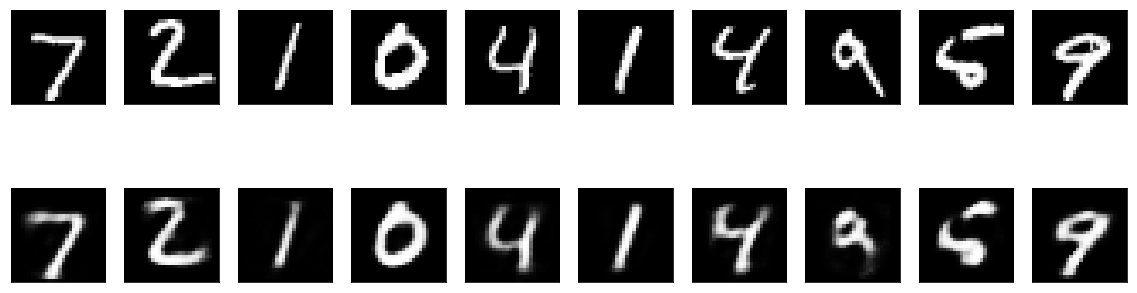

In [162]:
n = 10
plt.figure(figsize=(20, 6))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_val[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

The following code only works if the encoder is compiled during this session

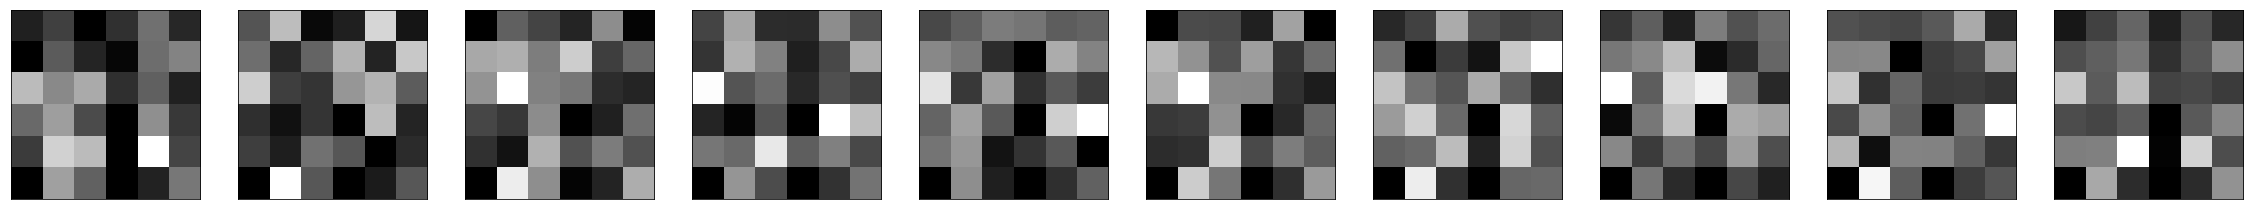

In [163]:
n = 10
plt.figure(figsize=(40, 10))
for i in range(n):  
    # display encoded
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(encoded_imgs[i].reshape(6, 6))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

Some Neurons are always 0. Further investigation?

# Stacked Autoencoder

In [164]:
######## constants for stacked autoencoder ############
input_dim = 784
encoding_dim1 = 128
encoding_dim2 = 64
encoding_dim3 = 32
decoding_dim1 = 64
decoding_dim2 = 128
decoding_dim3 = input_dim
epochs = 100
batch_size = 256

In [165]:
input_img = Input(shape=(input_dim,))
encoded = Dense(encoding_dim1, activation='relu')(input_img)
encoded = Dense(encoding_dim2, activation='relu')(encoded)
encoded = Dense(encoding_dim3, activation='relu')(encoded)

decoded = Dense(decoding_dim1, activation='relu')(encoded)
decoded = Dense(decoding_dim2, activation='relu')(decoded)
decoded = Dense(decoding_dim3, activation='sigmoid')(decoded)

In [166]:
stacked_autoencoder = Model(input_img, decoded)
stacked_autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
stacked_autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        (None, 784)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 128)               100480    
_________________________________________________________________
dense_23 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_24 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_25 (Dense)             (None, 64)                2112      
_________________________________________________________________
dense_26 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_27 (Dense)             (None, 784)               101136    
Total para

In [167]:
# stacked_autoencoder = keras.models.load_model('models/stacked_autoencoder.h5')
stacked_autoencoder.fit(x_train, x_train,
                epochs=epochs,
                batch_size=batch_size,
                shuffle=True,
                validation_data=(x_val, x_val))

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 8s 133us/step - loss: 0.3401 - val_loss: 0.2632
Epoch 2/100
60000/60000 [==============================] - 6s 106us/step - loss: 0.2558 - val_loss: 0.2465
Epoch 3/100
60000/60000 [==============================] - 6s 106us/step - loss: 0.2358 - val_loss: 0.2247
Epoch 4/100
60000/60000 [==============================] - 6s 106us/step - loss: 0.2180 - val_loss: 0.2079
Epoch 5/100
60000/60000 [==============================] - 6s 106us/step - loss: 0.2037 - val_loss: 0.1957
Epoch 6/100
60000/60000 [==============================] - 6s 106us/step - loss: 0.1901 - val_loss: 0.1825
Epoch 7/100
60000/60000 [==============================] - 6s 108us/step - loss: 0.1803 - val_loss: 0.1748
Epoch 8/100
60000/60000 [==============================] - 6s 107us/step - loss: 0.1747 - val_loss: 0.1708
Epoch 9/100
60000/60000 [==============================] - 6s 106us/step - loss: 0.1695 - val_

60000/60000 [==============================] - 6s 103us/step - loss: 0.1043 - val_loss: 0.1031
Epoch 77/100
60000/60000 [==============================] - 6s 104us/step - loss: 0.1039 - val_loss: 0.1026
Epoch 78/100
60000/60000 [==============================] - 7s 110us/step - loss: 0.1036 - val_loss: 0.1025
Epoch 79/100
60000/60000 [==============================] - 7s 110us/step - loss: 0.1034 - val_loss: 0.1025
Epoch 80/100
60000/60000 [==============================] - 6s 103us/step - loss: 0.1031 - val_loss: 0.1013
Epoch 81/100
60000/60000 [==============================] - 6s 103us/step - loss: 0.1028 - val_loss: 0.1011
Epoch 82/100
60000/60000 [==============================] - 6s 103us/step - loss: 0.1028 - val_loss: 0.1022
Epoch 83/100
60000/60000 [==============================] - 6s 104us/step - loss: 0.1025 - val_loss: 0.1021
Epoch 84/100
60000/60000 [==============================] - 6s 103us/step - loss: 0.1022 - val_loss: 0.1010
Epoch 85/100
60000/60000 [===============

Save the model

In [197]:
# stacked_autoencoder.save('models/stacked_autoencoder.h5')

In [169]:
score = stacked_autoencoder.evaluate(x_val, x_val, verbose=0)
print(score)

0.0978399471402


In [170]:
decoded_imgs = stacked_autoencoder.predict(x_val)

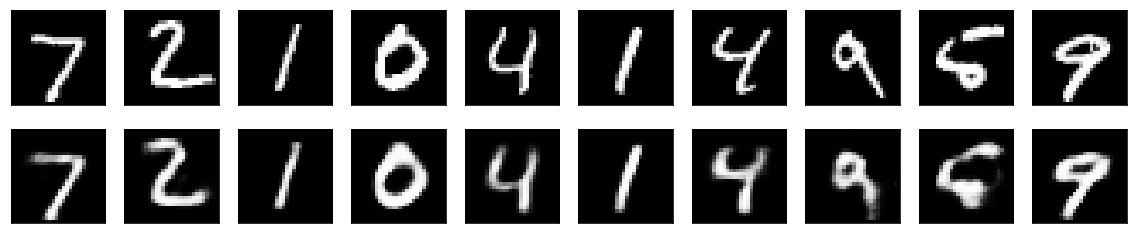

In [171]:
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_val[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# Denoising Data

In [172]:
noise_factor = 0.5

In [173]:
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_val_noisy = x_val + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_val.shape) 

# re-normalization by clipping to the intervall (0,1)
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_val_noisy = np.clip(x_val_noisy, 0., 1.)

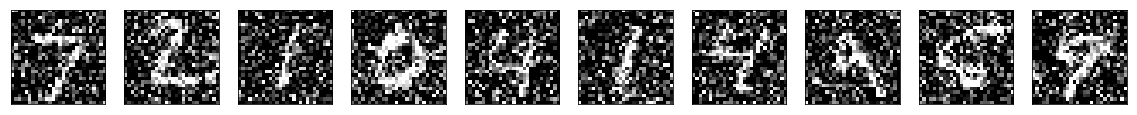

In [174]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(x_val_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Stick with the stack

In [175]:
denoising_autoencoder = Model(input_img, decoded)
denoising_autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
denoising_autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        (None, 784)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 128)               100480    
_________________________________________________________________
dense_23 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_24 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_25 (Dense)             (None, 64)                2112      
_________________________________________________________________
dense_26 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_27 (Dense)             (None, 784)               101136    
Total para

### Train or load a stacked denoising autoencoder

In [176]:
# denoising_autoencoder = keras.models.load_model('models/denoising_autoencoder.h5')
denoising_autoencoder.fit(x_train_noisy, x_train,
                epochs=epochs,
                batch_size=batch_size,
                shuffle=True,
                validation_data=(x_val_noisy, x_val),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 7s 117us/step - loss: 0.1428 - val_loss: 0.1360
Epoch 2/100
60000/60000 [==============================] - 7s 111us/step - loss: 0.1342 - val_loss: 0.1321
Epoch 3/100
60000/60000 [==============================] - 7s 111us/step - loss: 0.1313 - val_loss: 0.1299
Epoch 4/100
60000/60000 [==============================] - 7s 111us/step - loss: 0.1296 - val_loss: 0.1282
Epoch 5/100
60000/60000 [==============================] - 7s 111us/step - loss: 0.1284 - val_loss: 0.1274
Epoch 6/100
60000/60000 [==============================] - 7s 111us/step - loss: 0.1274 - val_loss: 0.1263
Epoch 7/100
60000/60000 [==============================] - 7s 110us/step - loss: 0.1267 - val_loss: 0.1279
Epoch 8/100
60000/60000 [==============================] - 7s 110us/step - loss: 0.1261 - val_loss: 0.1253
Epoch 9/100
60000/60000 [==============================] - 7s 110us/step - loss: 0.1256 - val_

60000/60000 [==============================] - 7s 111us/step - loss: 0.1158 - val_loss: 0.1174
Epoch 77/100
60000/60000 [==============================] - 7s 111us/step - loss: 0.1157 - val_loss: 0.1176
Epoch 78/100
60000/60000 [==============================] - 7s 111us/step - loss: 0.1158 - val_loss: 0.1173
Epoch 79/100
60000/60000 [==============================] - 7s 111us/step - loss: 0.1156 - val_loss: 0.1171
Epoch 80/100
60000/60000 [==============================] - 7s 111us/step - loss: 0.1156 - val_loss: 0.1174
Epoch 81/100
60000/60000 [==============================] - 7s 111us/step - loss: 0.1155 - val_loss: 0.1179
Epoch 82/100
60000/60000 [==============================] - 7s 111us/step - loss: 0.1155 - val_loss: 0.1173
Epoch 83/100
60000/60000 [==============================] - 7s 111us/step - loss: 0.1154 - val_loss: 0.1176
Epoch 84/100
60000/60000 [==============================] - 7s 111us/step - loss: 0.1153 - val_loss: 0.1169
Epoch 85/100
60000/60000 [===============

Save trained model

In [198]:
# denoising_autoencoder.save('models/denoising_autoencoder.h5')

In [178]:
decoded_imgs = denoising_autoencoder.predict(x_val_noisy)

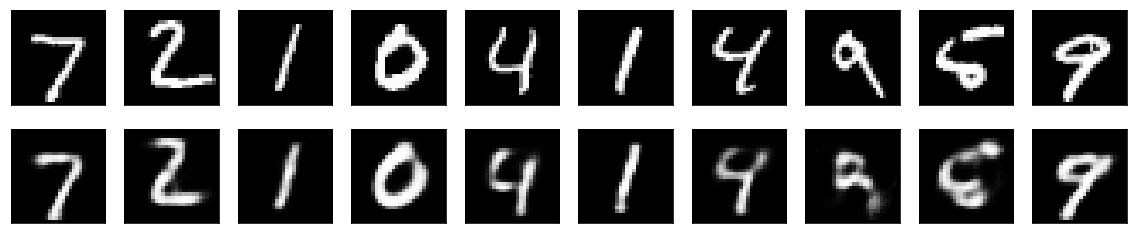

In [179]:
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_val[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# Train Neural Net to recognize MNIST digits

In [180]:
# constants
batch_size = 128
num_classes = 10
epochs = 20
hidden1_dim = 512
hidden2_dim = 512

## Preprocess input data

In [181]:
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)
print(y_train[0])

[ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]


In [182]:
model = Sequential()
model.add(Dense(hidden1_dim, activation='relu', input_shape=(input_dim,)))
model.add(Dropout(0.2))
model.add(Dense(hidden2_dim, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))

In [183]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_28 (Dense)             (None, 512)               401920    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_29 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_30 (Dense)             (None, 10)                5130      
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
_________________________________________________________________


In [184]:
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

### Train or load Model

In [185]:
# model = keras.models.load_model('models/model.h5')
model.fit(x_train, y_train, 
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_val, y_val))

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 14s 242us/step - loss: 0.2484 - acc: 0.9235 - val_loss: 0.1100 - val_acc: 0.9666
Epoch 2/20
60000/60000 [==============================] - 13s 223us/step - loss: 0.1029 - acc: 0.9686 - val_loss: 0.0844 - val_acc: 0.9734
Epoch 3/20
60000/60000 [==============================] - 13s 221us/step - loss: 0.0765 - acc: 0.9774 - val_loss: 0.0737 - val_acc: 0.9800
Epoch 4/20
60000/60000 [==============================] - 13s 221us/step - loss: 0.0597 - acc: 0.9816 - val_loss: 0.0791 - val_acc: 0.9780
Epoch 5/20
60000/60000 [==============================] - 13s 221us/step - loss: 0.0517 - acc: 0.9849 - val_loss: 0.0796 - val_acc: 0.9779
Epoch 6/20
60000/60000 [==============================] - 13s 221us/step - loss: 0.0426 - acc: 0.9867 - val_loss: 0.0783 - val_acc: 0.9805
Epoch 7/20
60000/60000 [==============================] - 13s 222us/step - loss: 0.0368 - acc: 0.9891 - val_loss: 0.

Save trained model

In [199]:
# model.save('models/model.h5')

In [188]:
score = model.evaluate(x_val, y_val, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.105847611373
Test accuracy: 0.9847


# Compare results

## Classification of noisy data

In [192]:
score = model.evaluate(x_val_noisy, y_val, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 9.14850905151
Test accuracy: 0.3805


## Classification of denoised data

In [194]:
score = model.evaluate(decoded_imgs, y_val, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.386431885328
Test accuracy: 0.9408


# Additional Information and Footage

## Cross Entropy

![Cross Entropy](images\2017-12-03 10_42_19-Machine Learning_ Should I use a categorical cross entropy or binary cross entro.png)

## Batch Size

Batch size defines number of samples that going to be propagated through the network.

For instance, let's say you have 1050 training samples and you want to set up batch_size equal to 100. Algorithm takes first 100 samples (from 1st to 100th) from the training dataset and trains network. Next it takes second 100 samples (from 101st to 200th) and train network again. We can keep doing this procedure until we will propagate through the networks all samples. The problem usually happens with the last set of samples. In our example we've used 1050 which is not divisible by 100 without remainder. The simplest solution is just to get final 50 samples and train the network.

Advantages:

* It requires less memory. Since you train network using less number of samples the overall training procedure requires less memory. It's especially important in case if you are not able to fit dataset in memory.
* Typically networks trains faster with mini-batches. That's because we update weights after each propagation. In our example we've propagated 11 batches (10 of them had 100 samples and 1 had 50 samples) and after each of them we've updated network's parameters. If we used all samples during propagation we would make only 1 update for the network's parameter.

Disadvantages:

* The smaller the batch the less accurate estimate of the gradient. In the figure below you can see that mini-batch (green color) gradient's direction fluctuates compare to the full batch (blue color).

![https://stats.stackexchange.com/questions/153531/what-is-batch-size-in-neural-network](images\lU3sx.png)